In [1]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

In [2]:
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization, Resizing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [3]:
import cv2

In [4]:
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [7]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [8]:
img_size = 96
X_train = np.array([cv2.resize(x, (img_size, img_size), interpolation = cv2.INTER_AREA) for x in X_train])
X_val = np.array([cv2.resize(x, (img_size, img_size), interpolation = cv2.INTER_AREA) for x in X_val])
X_test = np.array([cv2.resize(x, (img_size, img_size), interpolation = cv2.INTER_AREA) for x in X_test])

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet', pooling='avg')

In [10]:
base_model.trainable = True

In [9]:
inp = tf.keras.layers.Input(shape=(img_size,img_size,3))

In [10]:
# resized = Resizing(224,224)(inp)

In [13]:
x = base_model(inp)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inp, pred)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 1280)             2257984   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [10]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [11]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [19]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS)


Epoch 1/5
1328/1328 [==============================] - 82s 49ms/step - loss: 0.6541 - accuracy: 0.7957 - val_loss: 0.5467 - val_accuracy: 0.8288
Epoch 2/5
1328/1328 [==============================] - 61s 46ms/step - loss: 0.2853 - accuracy: 0.9046 - val_loss: 0.3406 - val_accuracy: 0.8925
Epoch 3/5
1328/1328 [==============================] - 64s 48ms/step - loss: 0.1831 - accuracy: 0.9379 - val_loss: 0.2704 - val_accuracy: 0.9184
Epoch 4/5
1328/1328 [==============================] - 62s 47ms/step - loss: 0.1341 - accuracy: 0.9537 - val_loss: 0.2574 - val_accuracy: 0.9287
Epoch 5/5
1328/1328 [==============================] - 64s 48ms/step - loss: 0.1047 - accuracy: 0.9642 - val_loss: 0.3682 - val_accuracy: 0.9044


In [20]:
model.save('mobv2_v4.h5')

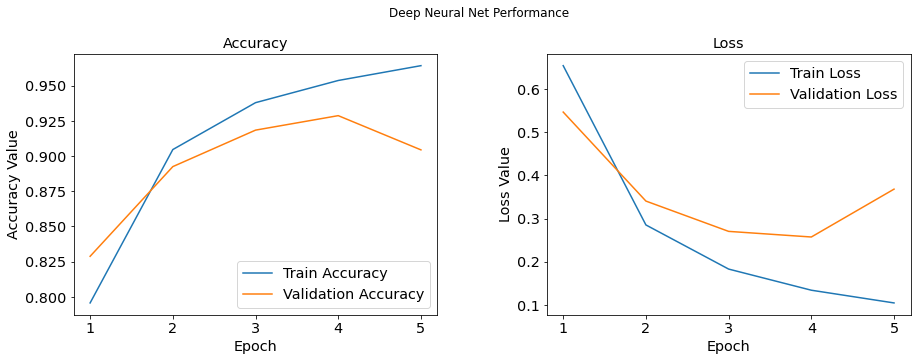

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [10]:
predictions = model.predict(X_test/255.)

In [11]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

In [12]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [13]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.9005
Precision: 0.9075
Recall: 0.9005
F1 Score: 0.9007


In [12]:
model = tf.keras.models.load_model('mobv2_v4.h5')

In [13]:

predictions = model.predict(X_test/255.)
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.9118
Precision: 0.9163
Recall: 0.9118
F1 Score: 0.9124


In [5]:
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 4.7 MB/s 


In [13]:
import tensorflow_model_optimization as tfmot

In [14]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [15]:
batch_size = 32
epochs = 25
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

In [16]:
# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.60,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

In [17]:
model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optim = tf.keras.optimizers.Adam(learning_rate=0.0007)
model_for_pruning.compile(optimizer=optim,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 1280)             4383709   
 onal)                                                           
                                                                 
 prune_low_magnitude_dropout  (None, 1280)             1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense (  (None, 10)               25612     
 PruneLowMagnitude)                                              
                                                                 
Total params: 4,409,322
Trainable params: 2,236,682
Non-trainable params: 2,172,640
___________________________________________

In [ ]:
logdir = 'logs/'
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
model_for_pruning
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history_pruned = model_for_pruning.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=epochs,callbacks=callbacks)
# model_for_pruning.fit(X_train, Y_train,
#                   batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

Epoch 1/25
   6/1328 [..............................] - ETA: 1:51 - loss: 0.2380 - accuracy: 0.9062

1328/1328 [==============================] - 166s 90ms/step - loss: 0.4472 - accuracy: 0.8525 - val_loss: 3.6564 - val_accuracy: 0.3869
Epoch 2/25
1328/1328 [==============================] - 116s 87ms/step - loss: 0.2902 - accuracy: 0.9020 - val_loss: 1.6689 - val_accuracy: 0.6311
Epoch 3/25
1328/1328 [==============================] - 117s 88ms/step - loss: 0.2311 - accuracy: 0.9207 - val_loss: 2.9540 - val_accuracy: 0.4606
Epoch 4/25
1328/1328 [==============================] - 115s 86ms/step - loss: 0.1963 - accuracy: 0.9327 - val_loss: 1.3672 - val_accuracy: 0.7237
Epoch 5/25
1328/1328 [==============================] - 115s 87ms/step - loss: 0.1641 - accuracy: 0.9433 - val_loss: 2.3911 - val_accuracy: 0.5040
Epoch 6/25
1328/1328 [==============================] - 116s 87ms/step - loss: 0.1412 - accuracy: 0.9516 - val_loss: 1.0450 - val_accuracy: 0.7640
Epoch 7/25
1328/1328 [==============================] - 116s 87ms/step - loss: 0.1328 - accuracy: 0.9541 - val_loss: 0.7499 - val

In [21]:
history_pruned = model_for_pruning.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=20,callbacks=callbacks)

Epoch 1/20
   6/1328 [..............................] - ETA: 2:29 - loss: 0.1949 - accuracy: 0.9271

1328/1328 [==============================] - 133s 99ms/step - loss: 0.1939 - accuracy: 0.9370 - val_loss: 0.5514 - val_accuracy: 0.8486
Epoch 2/20
1328/1328 [==============================] - 132s 99ms/step - loss: 0.1732 - accuracy: 0.9428 - val_loss: 0.5552 - val_accuracy: 0.8416
Epoch 3/20
1328/1328 [==============================] - 129s 97ms/step - loss: 0.1489 - accuracy: 0.9504 - val_loss: 0.6258 - val_accuracy: 0.8396
Epoch 4/20
1328/1328 [==============================] - 127s 96ms/step - loss: 0.1411 - accuracy: 0.9541 - val_loss: 1.0798 - val_accuracy: 0.7732
Epoch 5/20
1328/1328 [==============================] - 126s 95ms/step - loss: 0.1349 - accuracy: 0.9573 - val_loss: 0.6183 - val_accuracy: 0.8440
Epoch 6/20
1328/1328 [==============================] - 121s 91ms/step - loss: 0.1245 - accuracy: 0.9603 - val_loss: 0.8107 - val_accuracy: 0.8255
Epoch 7/20
1328/1328 [==============================] - 123s 93ms/step - loss: 0.1067 - accuracy: 0.9661 - val_loss: 0.7667 - val

In [22]:
pruned_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [23]:
pruned_model.save("pruned_v2.h5")

In [9]:
pruned_model = tf.keras.models.load_model('pruned_v2.h5')

In [12]:
predictions = pruned_model.predict(X_test/255.)
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.8805
Precision: 0.8887
Recall: 0.8805
F1 Score: 0.8824


In [ ]:
'''
Pruned Model size = 10.1MB
Default Model size = 
'''